# Typhoon Prediction Project
* Predict the trajectory of typhoons
    * 6h, 12h, 18h, 24h, ...
* LSTM, GRU

In [2]:
import pandas as pd
# from pandas.core.common import SettingWithCopyWarning
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import mean_absolute_error, f1_score
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import geopandas as gpd
from shapely.geometry import LineString
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pd.set_option('mode.chained_assignment', None)
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    device = 'cpu'
    print('CUDA is not available. Training on CPU...')
else:
    device = 'cuda'

In [3]:
## 전처리
def drop_str(data):
    cnt=0
    for y,m,d,t in zip(data["Year"],data["Month"],data["Date"],data["Time"]):
            data["Year"][cnt] = y.split("년")[0]
            data["Month"][cnt] = m.split("월")[0]
            data["Date"][cnt] = d.split("일")[0]
            data["Time"][cnt] = t.split("시")[0]
            cnt+=1
    return data
def str2int(data):
    data["Year"]=0
    data["Month"]=0
    data["Date"]=0
    data["Time"]=0
    for i, element in enumerate(data["일시"]):
        data["Year"][i]=element.split(' ')[0]
        data["Month"][i]=element.split(' ')[1]
        data["Date"][i]=element.split(' ')[2]
        data["Time"][i]=element.split(' ')[3]
    return data
def cat_1(data):
    strength_map={}
    for i, s in enumerate(data["강도"].unique()):
        strength_map[s] = i
    data["강도"] = data["강도"].map(strength_map)
    return data
def cat_2(data):
    for i, s in enumerate(data["크기"]):
        if s=="-":
            data["크기"][i] = 0
        elif s=="소형":
            data["크기"][i] = 1
        elif s=="중형":
            data["크기"][i] = 2
        else:
            data["크기"][i] = 3
    return data
def prepro(data):
    idx = data[data["Unnamed: 1"]!=0].index
    data = data.drop(idx)
    data = data.reset_index()
    data = str2int(data)
    drop_str(data)
    data =cat_1(data)
    data =cat_2(data)
    data = data.drop(["진행방향","70% 확률 반경(km)", "Unnamed: 1","일시","index"], axis=1)
    return data

In [4]:
data_dir = "C:/Lab/Capstone/Typhoon/tp_"
data = []

In [5]:
## csv 순서대로읽어와서 data에 저장
for i in range(1,529):
    data.append(pd.read_csv(data_dir+str(i).zfill(3)+".csv",encoding_errors='ignore',encoding="cp949"))

In [6]:
Hin = data[521]
Megi = data[512]
del(data[521])
del(data[512])

In [7]:
for i in range(len(data)):
    data[i]=prepro(data[i])
    #data[i].insert(0,'ID', i)
Hin = prepro(Hin)
Megi = prepro(Megi)


In [8]:
### The longest time series length
min=999
max=0
for i in range(len(data)):
    if max < data[i].shape[0]:
        max = data[i].shape[0]
    if min > data[i].shape[0]:
        min = data[i].shape[0]
print(min)
print(max)

2
74


In [9]:
for i in range(len(data)):
    data[i] = data[i].drop(["Year","Month","Date","Time"],axis=1)
Hin = Hin.drop(["Year","Month","Date","Time"],axis=1)
Megi = Megi.drop(["Year","Month","Date","Time"],axis=1)

In [10]:
# for i in range(len(data)):
#     data[i] = data[i].drop(["ID"],axis=1)
# Hin = Hin.drop(["ID"],axis=1)

In [11]:
for i in range(len(data)):
    data[i] = data[i].fillna(0)

In [12]:
# sc1 = MinMaxScaler()
# sc2 = MinMaxScaler()

# for i in range(len(data)):
#     data[i][['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','강도','크기','이동속도(km/h)']]=sc1.fit_transform(data[i][['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','강도','크기','이동속도(km/h)']])
#     data[i][['위도(N)','경도(E)']] = sc2.fit_transform(data[i][['위도(N)','경도(E)']])

In [13]:
minmax = {}
for j in ['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','강도','크기','이동속도(km/h)']:
    m = np.inf
    M = -np.inf
    for i in range(len(data)):
        m = m if np.min(data[i][[j]].values) > m else np.min(data[i][[j]].values)
        # if m == -1 :
            # print(i, end = ' ')
    for i in range(len(data)):
        M = M if np.max(data[i][[j]].values) < M  else np.max(data[i][[j]].values)
    minmax[j] = [m,M]
    print('min', m)
    print('max', M)

min 1.6
max 54.0
min 99.8
max 180.0
min 0
max 1010
min -1
max 61
min -4
max 220
min 0
max 1480.0
min 0
max 5
min 0
max 3
min 0.0
max 216


In [14]:
for i in range(len(data)):
    for j in ['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','강도','크기','이동속도(km/h)']:
        data[i][j] = (data[i][j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])

### With_padding

In [15]:
# for i in range(len(data)):
#     pad = nn.ConstantPad2d((0,0,0,max-data[i].shape[0]),0)
#     data[i]=pad(torch.tensor(data[i].values, dtype=torch.float32))

# y=[]
# for i in range(len(data)):
#     y.append(data[i][:,0:2])

# for i in range(len(data)):
#     data[i] = data[i][:,2:]

### Without_padding

In [16]:
y=[]
for i in range(len(data)):
    y.append(pd.concat([data[i][:]['위도(N)'],data[i][:]['경도(E)']],axis=1))

for i in range(len(data)):
    data[i] = data[i].drop(['위도(N)','경도(E)'], axis=1)

for i in range(len(data)):
    data[i] = torch.tensor(data[i].values, dtype=torch.float32)
    y[i] = torch.tensor(y[i].values, dtype=torch.float32)


In [17]:
x_train, x_valid, y_train, y_valid = train_test_split(data, y, test_size=0.1,random_state=42,shuffle=False)

# 전처리 끝

In [18]:
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]
    
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=10)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=10)
    
    return xx_pad, yy_pad

In [19]:
class my_dataset(Dataset):
    def __init__(self, data, y):
        self.data = data
        self.target = y
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, i):
        return self.data[i], self.target[i]

In [270]:
batch_size = 8
input_size = 7
hidden_size = 8
num_layer = 2
output_size = 2
MAX_LENGTH = 74
# embedding_size = 32

In [271]:
train_dataset = my_dataset(x_train, y_train)
valid_dataset = my_dataset(x_valid, y_valid)
train_loader = DataLoader(train_dataset, batch_size, shuffle=False, collate_fn = pad_collate)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False, collate_fn = pad_collate)

### Encoder

In [272]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size,batch_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.batch_size = batch_size
        
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        
    def forward(self, input, hidden):
        
        output, hidden = self.gru(input, hidden)
        
        return output, hidden
        
    def initHidden(self, batch_size):
        return torch.zeros(1,batch_size,self.hidden_size)

### Decoder

In [273]:
class DecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size, batch_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        
        self.gru = nn.GRU(output_size, hidden_size, batch_first=True)
        
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        
        output, hidden = self.gru(input, hidden)
        # print(output.shape, hidden.shape)
        output = self.out(output)
        # print(output.shape)
        
        return output, hidden
    
    def initHidden(self, batch_size):
        return torch.zeros(1,batch_size,self.hidden_size)

### Linear

In [274]:
# class Emb(nn.Module):
#     def __init__(self, hidden_size, output_size):
#         super(Emb, self).__init__()
#         self.hidden_size = hidden_size
#         self.output_size = output_size
        
#         self.emb = nn.Linear(hidden_size, output_size)
        
#     def forward(self, input):
#         output = self.emb(input)
#         return output

In [275]:
# class model(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, batch_size):
#         super(EncoderRNN, DecoderRNN, Emb, self).__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.output_size = output_size
#         self.batch_size = batch_size
        
        

In [276]:
def mse_loss(data, target, ignored_index):
    mask = (target == ignored_index)
    o_loss = nn.MSELoss(reduction = 'mean')
    m_data = data[~mask]
    m_target = target[~mask]
    loss = o_loss(m_data, m_target)
    return loss

In [283]:
epoch = 300
learning_rate = 0.00001
encoder = EncoderRNN(input_size, hidden_size, batch_size)
decoder = DecoderRNN(output_size, hidden_size, batch_size)
# embeder = Emb(hidden_size, output_size)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epoch,verbose=True)
encoder.to(device)
decoder.to(device)
# embeder.to(device)
encoder_optimizer = optim.Adam(encoder.parameters(), lr = learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr = learning_rate)
# embeder_optimizer = optim.Adam(embeder.parameters(), lr = learning_rate)

criterion = mse_loss

# Save training loss
train_loss = torch.zeros(epoch)
valid_loss_min = np.Inf
# Save validation loss
valid_loss = torch.zeros(epoch)
for e in trange(epoch):
    encoder.train()
    decoder.train()
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        # print(type(data))

        encoder_hidden = encoder.initHidden(label.shape[0])
        encoder_hidden = encoder_hidden.to(device)
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        embeder_optimizer.zero_grad()
        
        input_length = data.size(1)
        target_length = label.size(1)
        
        # encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size).to(device)
        
        
        # Encoder
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(data[:,ei,:].reshape(label.shape[0],1,-1), encoder_hidden)
            
        # Decoder_init
        decoder_input = label[:,0,:].reshape(label.shape[0],1,2)
        # print(decoder_input.shape)
        decoder_hidden = encoder_hidden
        # print(decoder_hidden.shape)
        
        # Decoder
        for di in range(target_length):
            # print(decoder_input.size(), decoder_hidden.size())
            # print(decoder_input.size(), decoder_hidden.size())
            decoder_output, decoder_hidden = decoder(decoder_input,decoder_hidden)
            
            # print(decoder_input[:,di,:].shape, label[:,di,:].reshape(1,1,-1).shape)
            # output = embeder(decoder_output)
            # print(output.shape)
            loss=criterion(decoder_output, label[:,di,:].reshape(label.shape[0],1,-1),ignored_index=10)
            decoder_input = decoder_output
            # print(decoder_output.shape)
            train_loss[e] += loss.item()
        loss.backward(retain_graph = True)
        encoder_optimizer.step()
        decoder_optimizer.step()
        # embeder_optimizer.step()
    train_loss[e] /= len(train_loader)

    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        # embeder.eval()
        for data, label in valid_loader:
            data, label = data.to(device), label.to(device)
            
            encoder_hidden = encoder.initHidden(label.shape[0])
            encoder_hidden = encoder_hidden.to(device)

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            embeder_optimizer.zero_grad()

            input_length = data.size(1)
            target_length = label.size(1)

            # encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size).to(device)

            for ei in range(input_length):
                
                # print(data.size(), encoder_hidden.size())
                encoder_output, encoder_hidden = encoder(data[:,ei,:].reshape(label.shape[0],1,-1), encoder_hidden)
                # print(1)
                # encoder_outputs[ei] += encoder_output[0,0]

            decoder_input = label[:,0,:].reshape(label.shape[0],1,2)
            decoder_hidden = encoder_hidden

            for di in range(target_length):
                
                decoder_output, decoder_hidden = decoder(decoder_input,decoder_hidden)
                # print(decoder_output.shape, decoder_hidden.shape, label.shape)
                # output = embeder(decoder_output)
                loss=criterion(decoder_output, label[:,di,:].reshape(label.shape[0],1,-1),ignored_index=10)
                decoder_input = decoder_output          
                valid_loss[e] += loss.item()
        valid_loss[e] /= len(valid_loader)
        # scheduler.step()
    print(f'Epoch : {e},\ttrain_loss : {train_loss[e]}\tvalid_loss :{valid_loss[e]}')
    if (valid_loss[e] <= valid_loss_min):
        print(f'Valid loss decreased ({valid_loss_min:.6f} ==> {valid_loss[e]:.6f})...')
        valid_loss_min = valid_loss[e]
        torch.save(encoder.state_dict(),'Encoder.pt')
        torch.save(decoder.state_dict(),'Decoder.pt')

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch : 0,	train_loss : 7.763664722442627	valid_loss :7.048092842102051
Valid loss decreased (inf ==> 7.048093)...
Epoch : 1,	train_loss : 7.691673755645752	valid_loss :6.978532314300537
Valid loss decreased (7.048093 ==> 6.978532)...
Epoch : 2,	train_loss : 7.6209611892700195	valid_loss :6.909905910491943
Valid loss decreased (6.978532 ==> 6.909906)...
Epoch : 3,	train_loss : 7.5510430335998535	valid_loss :6.842091083526611
Valid loss decreased (6.909906 ==> 6.842091)...
Epoch : 4,	train_loss : 7.481888294219971	valid_loss :6.775054931640625
Valid loss decreased (6.842091 ==> 6.775055)...
Epoch : 5,	train_loss : 7.413458347320557	valid_loss :6.708765506744385
Valid loss decreased (6.775055 ==> 6.708766)...
Epoch : 6,	train_loss : 7.345757484436035	valid_loss :6.643203258514404
Valid loss decreased (6.708766 ==> 6.643203)...
Epoch : 7,	train_loss : 7.278738975524902	valid_loss :6.578355312347412
Valid loss decreased (6.643203 ==> 6.578355)...
Epoch : 8,	train_loss : 7.212410926818848	v

([<matplotlib.lines.Line2D at 0x1c0dc2814f0>],
 [<matplotlib.lines.Line2D at 0x1c0dc281670>])

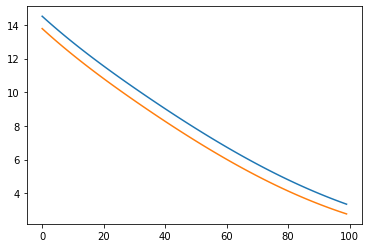

In [279]:
plt.plot(train_loss),plt.plot(valid_loss)

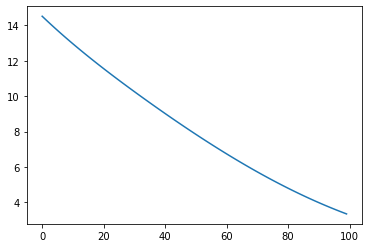

In [280]:
plt.plot(train_loss)

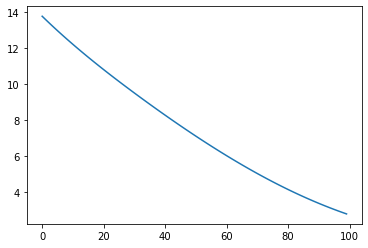

In [281]:
plt.plot(valid_loss)

In [241]:
Hin_X = Hin.drop(['위도(N)','경도(E)'],axis=1)
Hin_Y = pd.concat([Hin['위도(N)'],Hin['경도(E)']],axis=1)

Megi_X = Megi.drop(['위도(N)','경도(E)'],axis=1)
Megi_Y = pd.concat([Megi['위도(N)'],Megi['경도(E)']],axis=1)

In [242]:
for j in ['중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','강도','크기','이동속도(km/h)']:
        Hin_X[j] = (Hin_X[j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])
        Megi_X[j] = (Megi_X[j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])

In [243]:
for j in ['위도(N)','경도(E)']:
    Hin_Y[j] = (Hin_Y[j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])
    Megi_Y[j] = (Megi_Y[j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])

In [244]:
Hin_X=Hin_X.values.reshape(-1,44,7).astype(np.float32)
Megi_X=Megi_X.values.reshape(-1,9,7).astype(np.float32)
Hin_Y=Hin_Y.values.reshape(-1,44,2).astype(np.float32)
Megi_Y=Megi_Y.values.reshape(-1,9,2).astype(np.float32)

In [245]:
Hin_X = torch.tensor(Hin_X, dtype=torch.float32)
Megi_X = torch.tensor(Megi_X, dtype=torch.float32)
Hin_Y = torch.tensor(Hin_Y, dtype=torch.float32)
decoder_inputg = Hin_Y[:,0,:].to(device)
Megi_Y = torch.tensor(Megi_Y, dtype=torch.float32)
decoder_inputm = Megi_Y[:,0,:].to(device)

In [202]:
Hin_X.shape

torch.Size([1, 44, 7])

In [246]:
# encoder = EncoderRNN(input_size,hidden_size,batch_size)
# decoder = DecoderRNN()
encoder.load_state_dict(torch.load('./Encoder.pt'))
decoder.load_state_dict(torch.load('./Decoder.pt'))

<All keys matched successfully>

In [259]:
Hin_X = Hin_X.to(device)
hid = encoder.initHidden(1)
hid = hid.to(device)
# encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size).to(device)
for i in range(Hin_X.size(1)):
    out, hidden = encoder(Hin_X[:,i,:].reshape(1,1,-1),hid)
    # encoder_outputs[i] += out[0,0]
    
decoder_input = decoder_inputg.reshape(1,1,-1)

decoder_hidden = hidden

decode_path = []
# decode_path.append(decoder_inputm)
for i in range(1, Hin_X.size(1)):
    decoder_output , decoder_hidden = decoder(decoder_input, decoder_hidden)
    decoder_input = decoder_output
    decode_path.append(decoder_output)

In [260]:
len(decode_path)

43

In [261]:
decode_path[0].squeeze()[0].item()#.to('cpu').detach().numpy()

0.42342478036880493

In [262]:
decode_path[0].shape#[:,0]#.shape

torch.Size([1, 1, 2])

In [263]:
path_x=[]
path_y=[]
for i in range(len(decode_path)):
    path_x.append(decode_path[i].squeeze()[0].item()* (minmax['위도(N)'][1] - minmax['위도(N)'][0]) + minmax['위도(N)'][0])
    path_y.append(decode_path[i].squeeze()[1].item()* (minmax['경도(E)'][1] - minmax['경도(E)'][0]) + minmax['경도(E)'][0])

In [264]:
path_y[0]

130.9709681034088

In [265]:
path_x = pd.DataFrame(path_x)
path_y = pd.DataFrame(path_y)

In [266]:
pred1_path = pd.concat([path_x, path_y],axis=1)

In [267]:
pred1_path.columns=['위도','경도']

In [268]:
pred1_path

,위도,경도
0,23.787458,130.970968
1,22.316125,129.204889
2,21.916929,128.643092
3,21.941356,128.540634
4,22.087827,128.569445
5,22.234631,128.606478
6,22.344202,128.618084
7,22.413773,128.604319
8,22.452049,128.574541
9,22.469352,128.538067


In [121]:
pred1_path

,위도,경도
0,26.899999,148.500000
1,12.218810,97.708354
2,14.392501,100.191324
3,16.373591,101.904723
4,18.213064,103.442827
5,19.805033,104.785469
6,21.091963,105.928005
7,22.074829,106.893634
8,22.791211,107.702478
9,23.293778,108.367785


In [122]:
y[0]

tensor([[0.3130, 0.2406],
        [0.3397, 0.2594],
        [0.3912, 0.2855]])

C:\Users\jeonjw\anaconda3\envs\jeon\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

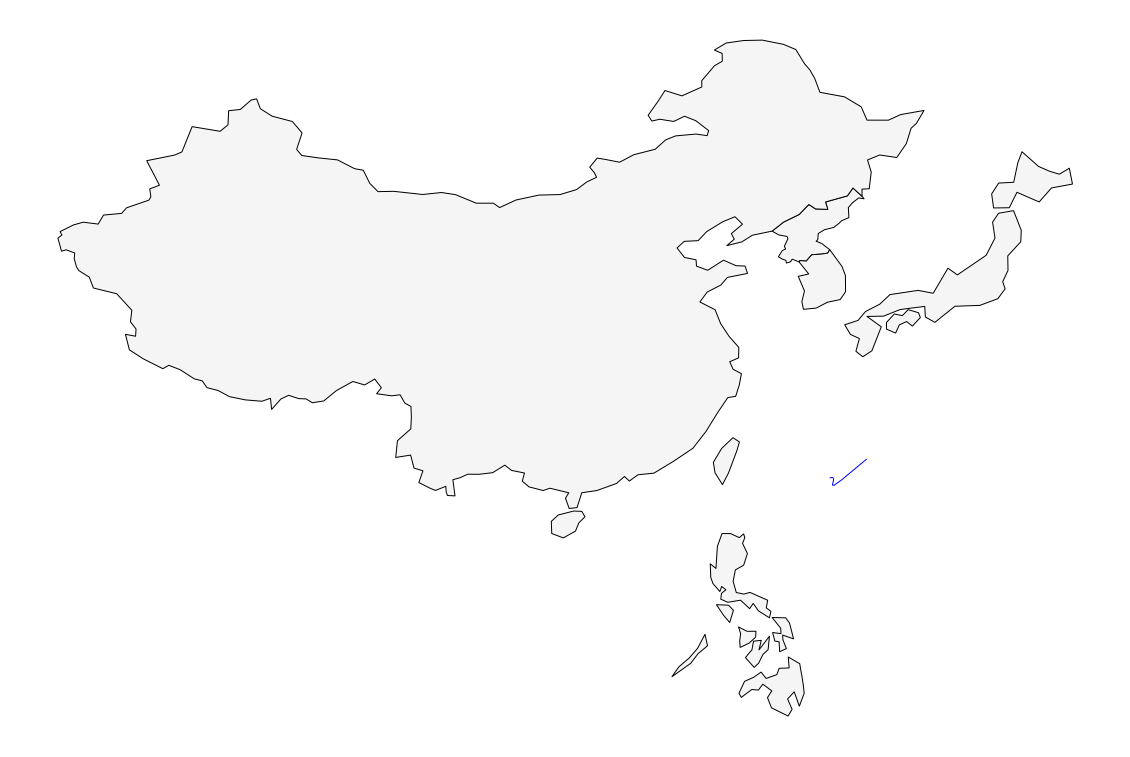

In [269]:
gdf_path = gpd.GeoDataFrame(pred1_path, geometry=gpd.points_from_xy(pred1_path[:]['경도'],pred1_path[:]['위도']), crs='epsg:4326')
line_geometry = LineString(gdf_path["geometry"])
df_path_line = pd.DataFrame({'geometry' : [line_geometry]})
gdf_path_line = gpd.GeoDataFrame(df_path_line, geometry=df_path_line.geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
basemap = world.loc[world['name'].isin(['South Korea', 'North Korea','Japan', 'China', 'Philippines','Taiwan'])]
ax = basemap.plot(figsize=(20,20), color='whitesmoke', edgecolor='black', linewidth=1)
ax.axis('off')
gdf_path_line.plot(ax=ax, linewidth=1., color='blue', zorder=1)

C:\Users\jeonjw\anaconda3\envs\jeon\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

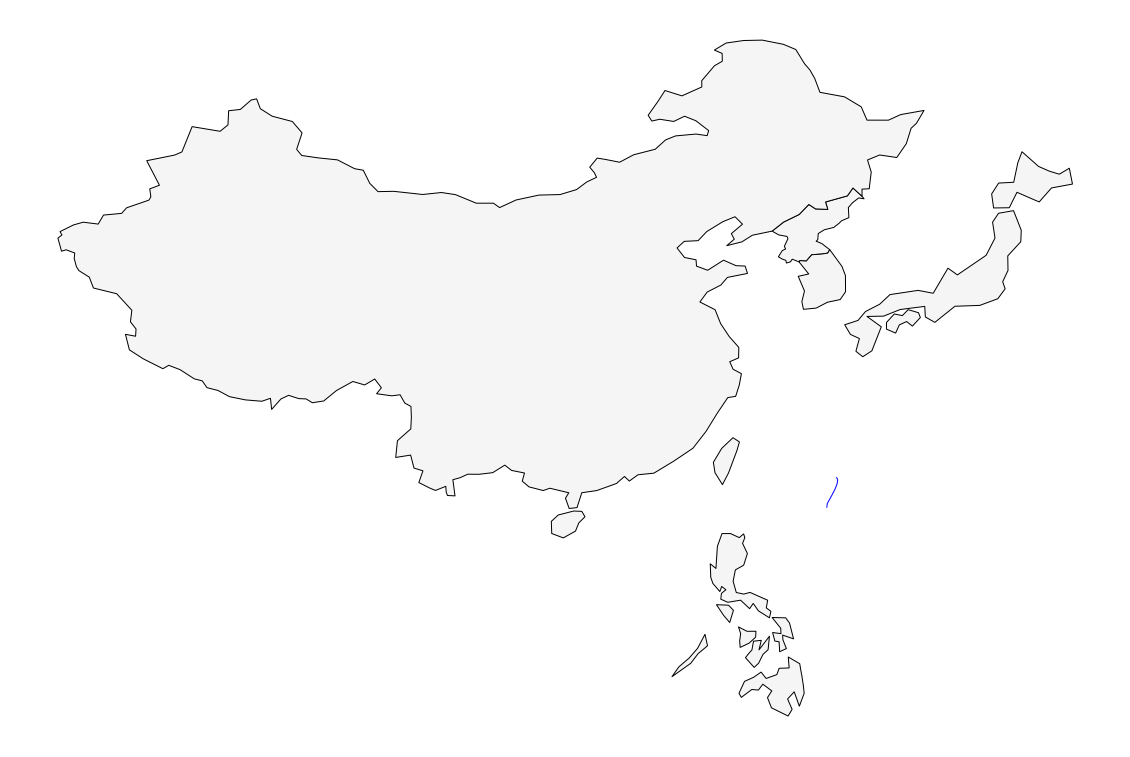

In [258]:
gdf_path = gpd.GeoDataFrame(pred1_path, geometry=gpd.points_from_xy(pred1_path[:]['경도'],pred1_path[:]['위도']), crs='epsg:4326')
line_geometry = LineString(gdf_path["geometry"])
df_path_line = pd.DataFrame({'geometry' : [line_geometry]})
gdf_path_line = gpd.GeoDataFrame(df_path_line, geometry=df_path_line.geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
basemap = world.loc[world['name'].isin(['South Korea', 'North Korea','Japan', 'China', 'Philippines','Taiwan'])]
ax = basemap.plot(figsize=(20,20), color='whitesmoke', edgecolor='black', linewidth=1)
ax.axis('off')
gdf_path_line.plot(ax=ax, linewidth=1., color='b', zorder=1)